In [10]:
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import scipy

np.random.seed(0)
tf.random.set_seed(1)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


0.8971437820318053

In [170]:
# parameters
n_grids = 350 # number of grid in grid search
R = 500 # number of Monte Carlo steps

def set_parameters(r1, r2):
    global N, M, const
    N = len(r1) # sample size of F
    M = len(r2) # sample size of G
    const = ((N*M/(N+M))**0.5)

def create_grids(r1, r2):
    global income
    _min = np.min([np.min(r1), np.min(r2)]) # find a common support for two incomes
    _max = np.max([np.max(r1), np.max(r2)])
    income = np.linspace(_min, _max, n_grids) # grids

def draw_random_multipliers():
    global U1_tensor, U2_tensor
#     U1 = stats.norm.rvs(size=(N, R))

    U1 = np.random.exponential(1, size=(N, R))
    U1_tensor = tf.constant(np.repeat(U1[None, ...], n_grids, 0)) # repeat for grid search dimension

#     U2 = stats.norm.rvs(size=(M, R))
    U2 = np.random.exponential(1, size=(M, R))
    U2_tensor = tf.constant(np.repeat(U2[None, ...], n_grids, 0)) # repeat for grid search dimension

def create_tensors(r1, r2):
    global N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 
    income_N_tensor = np.repeat(income[..., None], N, 1) # repeat for sample dimension
    income_N_tensor = np.repeat(income_N_tensor[..., None], R, 2) # repeat for MC dimension
    # income_N_tensor[0,0,0] == income_N_tensor[0,1,0] is True 
    # income_N_tensor[0,0,0] == income_N_tensor[0,0,1] is True 

    income_M_tensor = np.repeat(income[..., None], M, 1)
    income_M_tensor = np.repeat(income_M_tensor[..., None], R, 2)

    r1_tensor = np.repeat(r1[None, ...], n_grids, 0) # repeat for grid search dimension
    r1_tensor = np.repeat(r1_tensor[..., None], R, 2) # repeat for MC dimension
    r1_tensor = tf.constant(r1_tensor)

    r2_tensor = np.repeat(r2[None, ...], n_grids, 0)
    r2_tensor = np.repeat(r2_tensor[..., None], R, 2)
    r2_tensor = tf.constant(r2_tensor)


In [171]:
# Simple Numpy operation for S_hat 
def empirical_I(z, x, j):
    # x: one observation of the sample
    return (x <= z)*(z-x)**(j-1)/np.math.factorial(j-1)

def I(z, X, j):
    # Whole sample
    N = len(X)
    return 1/N*np.sum((X <= z)*(z-X)**(j-1))/np.math.factorial(j-1)

# Compute S_hat for given incomes r1 and r2
def S_hat_fn(r1, r2, j):
    global const, income
    fn = lambda z: (I(z, r2, j) - I(z, r1, j))
    a = np.array([fn(i) for i in income])
    
    S_hat1 = const*np.max(a)
    S_hat2 = -const*np.min(a)
    return S_hat1, S_hat2


In [172]:
# Make functions for Numpy adapt to Tensorflow Tensor
def empirical_I_tf(z, x, j):
    # x: one observation of the sample
    return tf.cast((x <= z), tf.float64)*tf.math.add(z, -x)**(j-1)/np.math.factorial(j-1)

def I_tf(z, X, j, N):
    # Whole sample
    A = tf.cast((X <= z), tf.float64)*tf.math.add(z, -X)**(j-1)
    A = tf.math.reduce_sum(A, axis=1, keepdims=True)
    A = tf.repeat(A, N, axis=1)
    return ((1/N)*A/np.math.factorial(j-1)).numpy()

def S_bar_fn(j):
    global N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 
    a = empirical_I_tf(income_N_tensor, r1_tensor, j)
    b = I_tf(income_N_tensor, r1_tensor, j, N)

    c = empirical_I_tf(income_M_tensor, r2_tensor, j)
    d = I_tf(income_M_tensor, r2_tensor, j, M)

    e = ((c-d)*U2_tensor) - ((a-b)*U1_tensor)
    f = tf.math.reduce_sum(e, axis=1)

    S_bar1 = const*tf.math.reduce_max(f, axis=0)
    S_bar2 = -const*tf.math.reduce_min(f, axis=0)
    return S_bar1, S_bar2

In [173]:
def make_decision(S_bar, S_hat):
    p = np.mean(S_bar > S_hat) 
    print('P-value =', p)

    if p < 0.05: # p-value
        print("Reject Null; r2 is not domaining r1 (crossing) OR r1 is domaining r2")
        return 1
    else:
        print("Cannot reject Null; r2 is domaining r1 OR r2==r1")
        return 0

In [174]:
# from google.colab import drive
# drive.mount('/content/drive/')

## Pilot Test

In [175]:
# import pickle
# with open('/content/drive/My Drive/00_IRTG1792/copula/Py_notebooks/v3_OOS_income.pickle', 'rb') as handle:
#     results = pickle.load(handle)

# Local
# the pickle is from jupyter notebook Py_notebooks/static and dynamic hedge results.ipynb
import pickle
with open('../Py_notebooks/static_results.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [176]:
results # this is same to slide 34 in the presentation

{('unhedged',
  'unhedged'): array([0.77469789, 0.87183463, 0.88372527, 0.91519056, 0.94571174,
        1.00438827, 1.1758855 , 1.06170717, 1.0943365 , 0.69341728,
        0.72067344, 0.7220773 , 0.75718937, 0.80619161, 0.93743388,
        1.05663588, 1.213873  , 1.24218539, 1.31891622, 1.23152968,
        1.19026326, 1.1102568 , 1.13032812, 1.0103646 , 0.9403249 ,
        0.9259217 , 0.95587298, 1.07979896, 1.23986474, 2.13450068,
        1.86107502, 1.75250025, 1.70387697, 1.66465264, 1.50236937,
        1.4179103 , 1.19199951, 1.23808326, 1.12368826, 1.29981308,
        1.37772043, 1.37634791, 1.60288383, 1.67267085, 1.95233362,
        1.80412943, 2.0465056 , 1.93953398, 2.02445871, 2.27349136,
        2.93876366, 2.9732999 , 3.04684181, 2.7291425 , 3.60305106]),
 ('future',
  'future'): array([0.80322266, 0.88029197, 0.88662487, 0.93833652, 0.97661958,
        1.03045187, 1.2350075 , 1.04945718, 1.08269344, 0.66252331,
        0.70688674, 0.71292225, 0.7704826 , 0.7987127 , 0.9279

-2.8091572387196093 9.709168342254804


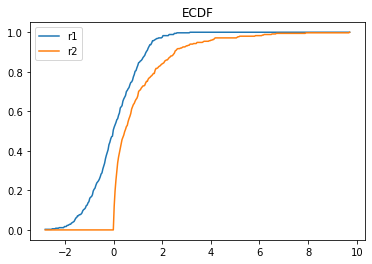

In [177]:
# two returns
# r1 = (stats.t.rvs(df=10, size=350)*0.8)+3
# r2 = (stats.t.rvs(df=10, size=350)*1.2)+3.1

# r1 = np.array(results[('unhedged', 'unhedged')]) # BTC returns
# r1 = np.array(results[('future'), ('future')])
# r1 = np.array(results[('Gumbel'), ('VaR 95%')])

# r2 = np.array(results[('Frank'), ('VaR 95%')])
# r2 = np.array(results[('Gaussian'), ('VaR 95%')])
# r2 = np.array(results[('Gumbel'), ('VaR 95%')])

r1 = stats.norm(0,1).rvs(350)

r2 = r1**2

ecdf1 = ECDF(r1)
ecdf2 = ECDF(r2)

_min = np.min([np.min(r1), np.min(r2)]) # find a common support for two incomes
_max = np.max([np.max(r1), np.max(r2)])
x = np.linspace(_min, _max, n_grids) # grids
print(_min, _max)
plt.plot(x, ecdf1(x), label='r1')
plt.plot(x, ecdf2(x), label='r2')
plt.title('ECDF')
plt.legend()

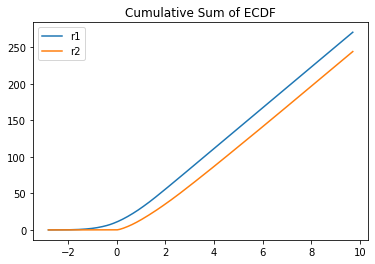

In [178]:
plt.plot(x, np.cumsum(ecdf1(x)), label='r1')
plt.plot(x, np.cumsum(ecdf2(x)), label='r2')
plt.title('Cumulative Sum of ECDF')
plt.legend()

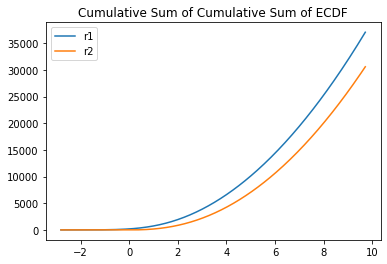

In [179]:
plt.plot(x, np.cumsum(np.cumsum(ecdf1(x))), label='r1')
plt.plot(x, np.cumsum(np.cumsum(ecdf2(x))), label='r2')
plt.title('Cumulative Sum of Cumulative Sum of ECDF')
plt.legend()
# plt.xlim((0.8,2))

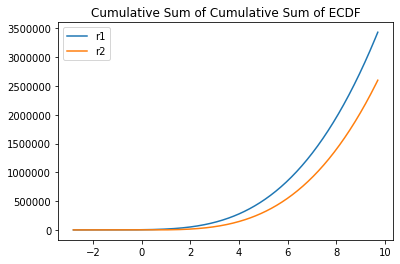

In [180]:
plt.plot(x, np.cumsum(np.cumsum(np.cumsum(ecdf1(x)))), label='r1')
plt.plot(x, np.cumsum(np.cumsum(np.cumsum(ecdf2(x)))), label='r2')
plt.title('Cumulative Sum of Cumulative Sum of ECDF')
plt.legend()
# plt.xlim((0.8,2))

In [181]:
df = pd.DataFrame({'r1':np.cumsum(np.cumsum(np.cumsum(ecdf1(x)))), 'r2':np.cumsum(np.cumsum(np.cumsum(ecdf2(x))))})
df.loc[:,'r1>r2'] = df.r1 > df.r2
df.loc[:,'x']=x
pd.set_option('display.max_rows', df.shape[0]+1)
df

,r1,r2,r1>r2,x
0,2.857143e-03,0.000000e+00,True,-2.809157
1,1.142857e-02,0.000000e+00,True,-2.773288
2,2.857143e-02,0.000000e+00,True,-2.737419
3,5.714286e-02,0.000000e+00,True,-2.701550
4,1.000000e-01,0.000000e+00,True,-2.665681
5,1.600000e-01,0.000000e+00,True,-2.629812
6,2.400000e-01,0.000000e+00,True,-2.593942
7,3.428571e-01,0.000000e+00,True,-2.558073
8,4.742857e-01,0.000000e+00,True,-2.522204
9,6.400000e-01,0.000000e+00,True,-2.486335


In [182]:
df = pd.DataFrame({'r1':np.cumsum(np.cumsum(ecdf1(x))), 'r2':np.cumsum(np.cumsum(ecdf2(x)))})
df.loc[:,'r1>r2'] = df.r1 > df.r2
df.loc[:,'x']=x
pd.set_option('display.max_rows', df.shape[0]+1)

In [183]:
df

,r1,r2,r1>r2,x
0,0.002857,0.000000,True,-2.809157
1,0.008571,0.000000,True,-2.773288
2,0.017143,0.000000,True,-2.737419
3,0.028571,0.000000,True,-2.701550
4,0.042857,0.000000,True,-2.665681
5,0.060000,0.000000,True,-2.629812
6,0.080000,0.000000,True,-2.593942
7,0.102857,0.000000,True,-2.558073
8,0.131429,0.000000,True,-2.522204
9,0.165714,0.000000,True,-2.486335


In [184]:
# test for SOSD
j = 2
try:
    del  N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 
except: 
    pass

set_parameters(r1, r2)
create_grids(r1, r2)
S_hat1, S_hat2 = S_hat_fn(r1, r2, j)

draw_random_multipliers()
create_tensors(r1, r2)
S_bar1, S_bar2 = S_bar_fn(j)

Ha = make_decision(S_bar1, S_hat1)
Hb = make_decision(S_bar2, S_hat2)
# sns.distplot(S_bar)

P-value = 0.918
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.768
Cannot reject Null; r2 is domaining r1 OR r2==r1


In [93]:
# test for TOSD
j = 3
try:
    del  N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 
except: 
    pass

set_parameters(r1, r2)
create_grids(r1, r2)
S_hat1, S_hat2 = S_hat_fn(r1, r2, j)

draw_random_multipliers()
create_tensors(r1, r2)
S_bar1, S_bar2 = S_bar_fn(j)

Ha = make_decision(S_bar1, S_hat1)
Hb = make_decision(S_bar2, S_hat2)
# sns.distplot(S_bar)

P-value = 0.854
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.224
Cannot reject Null; r2 is domaining r1 OR r2==r1


## Testing All Pairs

In [91]:
def run(r1, r2, j):
    try:
        del  N, M, income_N_tensor, income_M_tensor, r1_tensor, r2_tensor 
    except: 
        pass

    set_parameters(r1, r2)
    create_grids(r1, r2)
    S_hat1, S_hat2 = S_hat_fn(r1, r2, j)

    draw_random_multipliers()
    create_tensors(r1, r2)
    S_bar1, S_bar2 = S_bar_fn(j)

    Ha = make_decision(S_bar1, S_hat1)
    Hb = make_decision(S_bar2, S_hat2)
    return Ha, Hb

In [92]:
run(r1,r2,2)

P-value = 0.63
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.77
Cannot reject Null; r2 is domaining r1 OR r2==r1


(0, 0)

In [93]:
CR_pairs = list(results.keys()) # All Copula and Risk meausre pairs

In [94]:
# DONT RUN THIS FOR THE SECOND TIME! IT WILL OVERWRITE OLD FILE!
print("Total number of operation is", len(CR_pairs)**2/2-len(CR_pairs))

SOSD = np.ones([len(CR_pairs), len(CR_pairs)])+1000
SOSD = pd.DataFrame(SOSD, index=CR_pairs, columns=CR_pairs)
# save_file = '/content/drive/My Drive/00_IRTG1792/copula/Py_notebooks/SOSD.pickle'
save_file = '../Py_notebooks/SOSD_static.pickle'

for i, pair1 in enumerate(CR_pairs):
    for k, pair2 in enumerate(CR_pairs):
        if (k<i) or (k==i):
            pass 
        else:
            r1 = np.array(results[pair1])
            r2 = np.array(results[pair2])
            SOSD.iloc[i,k], SOSD.iloc[k,i] = run(r1, r2, j=2) # SOSD

            if (k%5 == 0):
                with open(save_file, 'wb') as handle:
                    pickle.dump(SOSD, handle)
            print(i,k)
            
with open(save_file, 'wb') as handle:
    pickle.dump(SOSD, handle)

Total number of operation is 1200.0
P-value = 0.846
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.812
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 1
P-value = 0.632
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.764
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 2
P-value = 0.618
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.768
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 3
P-value = 0.592
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.804
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 4
P-value = 0.632
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.758
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 5
P-value = 0.632
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.744
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 6
P-value = 0.636
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.758
Cannot reject Null; r2 is domaining r1 OR r2==r1
0 7
P-value = 0.66
Cannot reje

P-value = 0.648
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.796
Cannot reject Null; r2 is domaining r1 OR r2==r1
1 14
P-value = 0.628
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.788
Cannot reject Null; r2 is domaining r1 OR r2==r1
1 15
P-value = 0.67
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.77
Cannot reject Null; r2 is domaining r1 OR r2==r1
1 16
P-value = 0.634
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.79
Cannot reject Null; r2 is domaining r1 OR r2==r1
1 17
P-value = 0.642
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.76
Cannot reject Null; r2 is domaining r1 OR r2==r1
1 18
P-value = 0.61
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.786
Cannot reject Null; r2 is domaining r1 OR r2==r1
1 19
P-value = 0.68
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.772
Cannot reject Null; r2 is domaining r1 OR r2==r1
1 20
P-value = 0.672
Cannot reject Null; r2 is domaining r1 OR r2=

P-value = 0.728
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.818
Cannot reject Null; r2 is domaining r1 OR r2==r1
2 28
P-value = 0.67
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.776
Cannot reject Null; r2 is domaining r1 OR r2==r1
2 29
P-value = 0.632
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.812
Cannot reject Null; r2 is domaining r1 OR r2==r1
2 30
P-value = 0.65
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.804
Cannot reject Null; r2 is domaining r1 OR r2==r1
2 31
P-value = 0.804
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.754
Cannot reject Null; r2 is domaining r1 OR r2==r1
2 32
P-value = 0.746
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.808
Cannot reject Null; r2 is domaining r1 OR r2==r1
2 33
P-value = 0.842
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.772
Cannot reject Null; r2 is domaining r1 OR r2==r1
2 34
P-value = 0.768
Cannot reject Null; r2 is domaining r1 OR

P-value = 0.832
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.682
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 43
P-value = 0.814
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.676
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 44
P-value = 0.768
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.688
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 45
P-value = 0.85
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.674
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 46
P-value = 0.742
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.64
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 47
P-value = 0.794
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.656
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 48
P-value = 0.85
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.682
Cannot reject Null; r2 is domaining r1 OR r2==r1
3 49
P-value = 0.696
Cannot reject Null; r2 is domaining r1 OR 

P-value = 0.77
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.704
Cannot reject Null; r2 is domaining r1 OR r2==r1
5 15
P-value = 0.81
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.696
Cannot reject Null; r2 is domaining r1 OR r2==r1
5 16
P-value = 0.768
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.6
Cannot reject Null; r2 is domaining r1 OR r2==r1
5 17
P-value = 0.816
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.654
Cannot reject Null; r2 is domaining r1 OR r2==r1
5 18
P-value = 0.814
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.668
Cannot reject Null; r2 is domaining r1 OR r2==r1
5 19
P-value = 0.78
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.644
Cannot reject Null; r2 is domaining r1 OR r2==r1
5 20
P-value = 0.744
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.638
Cannot reject Null; r2 is domaining r1 OR r2==r1
5 21
P-value = 0.73
Cannot reject Null; r2 is domaining r1 OR r2=

P-value = 0.81
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.772
Cannot reject Null; r2 is domaining r1 OR r2==r1
6 33
P-value = 0.822
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.746
Cannot reject Null; r2 is domaining r1 OR r2==r1
6 34
P-value = 0.772
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.778
Cannot reject Null; r2 is domaining r1 OR r2==r1
6 35
P-value = 0.796
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.756
Cannot reject Null; r2 is domaining r1 OR r2==r1
6 36
P-value = 0.828
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.736
Cannot reject Null; r2 is domaining r1 OR r2==r1
6 37
P-value = 0.844
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.67
Cannot reject Null; r2 is domaining r1 OR r2==r1
6 38
P-value = 0.78
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.652
Cannot reject Null; r2 is domaining r1 OR r2==r1
6 39
P-value = 0.728
Cannot reject Null; r2 is domaining r1 OR 

P-value = 0.738
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.824
Cannot reject Null; r2 is domaining r1 OR r2==r1
8 11
P-value = 0.76
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.804
Cannot reject Null; r2 is domaining r1 OR r2==r1
8 12
P-value = 0.786
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.834
Cannot reject Null; r2 is domaining r1 OR r2==r1
8 13
P-value = 0.722
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.82
Cannot reject Null; r2 is domaining r1 OR r2==r1
8 14
P-value = 0.67
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.854
Cannot reject Null; r2 is domaining r1 OR r2==r1
8 15
P-value = 0.714
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.846
Cannot reject Null; r2 is domaining r1 OR r2==r1
8 16
P-value = 0.792
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.7
Cannot reject Null; r2 is domaining r1 OR r2==r1
8 17
P-value = 0.81
Cannot reject Null; r2 is domaining r1 OR r2=

P-value = 0.796
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.708
Cannot reject Null; r2 is domaining r1 OR r2==r1
9 32
P-value = 0.808
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.708
Cannot reject Null; r2 is domaining r1 OR r2==r1
9 33
P-value = 0.836
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.698
Cannot reject Null; r2 is domaining r1 OR r2==r1
9 34
P-value = 0.75
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.724
Cannot reject Null; r2 is domaining r1 OR r2==r1
9 35
P-value = 0.812
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.716
Cannot reject Null; r2 is domaining r1 OR r2==r1
9 36
P-value = 0.816
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.706
Cannot reject Null; r2 is domaining r1 OR r2==r1
9 37
P-value = 0.78
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.644
Cannot reject Null; r2 is domaining r1 OR r2==r1
9 38
P-value = 0.724
Cannot reject Null; r2 is domaining r1 OR

P-value = 0.788
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.732
Cannot reject Null; r2 is domaining r1 OR r2==r1
11 16
P-value = 0.806
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.636
Cannot reject Null; r2 is domaining r1 OR r2==r1
11 17
P-value = 0.798
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.72
Cannot reject Null; r2 is domaining r1 OR r2==r1
11 18
P-value = 0.792
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.72
Cannot reject Null; r2 is domaining r1 OR r2==r1
11 19
P-value = 0.78
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.642
Cannot reject Null; r2 is domaining r1 OR r2==r1
11 20
P-value = 0.748
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.598
Cannot reject Null; r2 is domaining r1 OR r2==r1
11 21
P-value = 0.732
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.784
Cannot reject Null; r2 is domaining r1 OR r2==r1
11 22
P-value = 0.752
Cannot reject Null; r2 is domaining

P-value = 0.72
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.822
Cannot reject Null; r2 is domaining r1 OR r2==r1
12 40
P-value = 0.694
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.658
Cannot reject Null; r2 is domaining r1 OR r2==r1
12 41
P-value = 0.814
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.728
Cannot reject Null; r2 is domaining r1 OR r2==r1
12 42
P-value = 0.782
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.81
Cannot reject Null; r2 is domaining r1 OR r2==r1
12 43
P-value = 0.802
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.668
Cannot reject Null; r2 is domaining r1 OR r2==r1
12 44
P-value = 0.764
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.728
Cannot reject Null; r2 is domaining r1 OR r2==r1
12 45
P-value = 0.816
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.664
Cannot reject Null; r2 is domaining r1 OR r2==r1
12 46
P-value = 0.774
Cannot reject Null; r2 is domainin

P-value = 0.624
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.836
Cannot reject Null; r2 is domaining r1 OR r2==r1
14 30
P-value = 0.66
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.824
Cannot reject Null; r2 is domaining r1 OR r2==r1
14 31
P-value = 0.822
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.736
Cannot reject Null; r2 is domaining r1 OR r2==r1
14 32
P-value = 0.79
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.78
Cannot reject Null; r2 is domaining r1 OR r2==r1
14 33
P-value = 0.816
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.748
Cannot reject Null; r2 is domaining r1 OR r2==r1
14 34
P-value = 0.794
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.768
Cannot reject Null; r2 is domaining r1 OR r2==r1
14 35
P-value = 0.82
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.752
Cannot reject Null; r2 is domaining r1 OR r2==r1
14 36
P-value = 0.796
Cannot reject Null; r2 is domaining 

P-value = 0.78
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.596
Cannot reject Null; r2 is domaining r1 OR r2==r1
16 24
P-value = 0.766
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.644
Cannot reject Null; r2 is domaining r1 OR r2==r1
16 25
P-value = 0.826
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.748
Cannot reject Null; r2 is domaining r1 OR r2==r1
16 26
P-value = 0.59
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.838
Cannot reject Null; r2 is domaining r1 OR r2==r1
16 27
P-value = 0.75
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.868
Cannot reject Null; r2 is domaining r1 OR r2==r1
16 28
P-value = 0.656
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.726
Cannot reject Null; r2 is domaining r1 OR r2==r1
16 29
P-value = 0.628
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.856
Cannot reject Null; r2 is domaining r1 OR r2==r1
16 30
P-value = 0.652
Cannot reject Null; r2 is domaining

P-value = 0.686
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.822
Cannot reject Null; r2 is domaining r1 OR r2==r1
18 22
P-value = 0.728
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.648
Cannot reject Null; r2 is domaining r1 OR r2==r1
18 23
P-value = 0.756
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.64
Cannot reject Null; r2 is domaining r1 OR r2==r1
18 24
P-value = 0.738
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.654
Cannot reject Null; r2 is domaining r1 OR r2==r1
18 25
P-value = 0.734
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.83
Cannot reject Null; r2 is domaining r1 OR r2==r1
18 26
P-value = 0.594
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.844
Cannot reject Null; r2 is domaining r1 OR r2==r1
18 27
P-value = 0.684
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.812
Cannot reject Null; r2 is domaining r1 OR r2==r1
18 28
P-value = 0.618
Cannot reject Null; r2 is domainin

P-value = 0.806
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.694
Cannot reject Null; r2 is domaining r1 OR r2==r1
20 24
P-value = 0.814
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.734
Cannot reject Null; r2 is domaining r1 OR r2==r1
20 25
P-value = 0.656
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.804
Cannot reject Null; r2 is domaining r1 OR r2==r1
20 26
P-value = 0.612
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.824
Cannot reject Null; r2 is domaining r1 OR r2==r1
20 27
P-value = 0.658
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.754
Cannot reject Null; r2 is domaining r1 OR r2==r1
20 28
P-value = 0.576
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.832
Cannot reject Null; r2 is domaining r1 OR r2==r1
20 29
P-value = 0.582
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.816
Cannot reject Null; r2 is domaining r1 OR r2==r1
20 30
P-value = 0.606
Cannot reject Null; r2 is domain

P-value = 0.748
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.752
Cannot reject Null; r2 is domaining r1 OR r2==r1
22 30
P-value = 0.74
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.738
Cannot reject Null; r2 is domaining r1 OR r2==r1
22 31
P-value = 0.824
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.678
Cannot reject Null; r2 is domaining r1 OR r2==r1
22 32
P-value = 0.768
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.766
Cannot reject Null; r2 is domaining r1 OR r2==r1
22 33
P-value = 0.8
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.748
Cannot reject Null; r2 is domaining r1 OR r2==r1
22 34
P-value = 0.756
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.724
Cannot reject Null; r2 is domaining r1 OR r2==r1
22 35
P-value = 0.798
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.73
Cannot reject Null; r2 is domaining r1 OR r2==r1
22 36
P-value = 0.762
Cannot reject Null; r2 is domaining 

P-value = 0.646
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.768
Cannot reject Null; r2 is domaining r1 OR r2==r1
24 40
P-value = 0.666
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.852
Cannot reject Null; r2 is domaining r1 OR r2==r1
24 41
P-value = 0.67
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.736
Cannot reject Null; r2 is domaining r1 OR r2==r1
24 42
P-value = 0.608
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.778
Cannot reject Null; r2 is domaining r1 OR r2==r1
24 43
P-value = 0.652
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.758
Cannot reject Null; r2 is domaining r1 OR r2==r1
24 44
P-value = 0.636
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.792
Cannot reject Null; r2 is domaining r1 OR r2==r1
24 45
P-value = 0.642
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.752
Cannot reject Null; r2 is domaining r1 OR r2==r1
24 46
P-value = 0.634
Cannot reject Null; r2 is domaini

P-value = 0.856
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.608
Cannot reject Null; r2 is domaining r1 OR r2==r1
27 32
P-value = 0.828
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.644
Cannot reject Null; r2 is domaining r1 OR r2==r1
27 33
P-value = 0.874
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.644
Cannot reject Null; r2 is domaining r1 OR r2==r1
27 34
P-value = 0.774
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.634
Cannot reject Null; r2 is domaining r1 OR r2==r1
27 35
P-value = 0.812
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.648
Cannot reject Null; r2 is domaining r1 OR r2==r1
27 36
P-value = 0.822
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.626
Cannot reject Null; r2 is domaining r1 OR r2==r1
27 37
P-value = 0.878
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.572
Cannot reject Null; r2 is domaining r1 OR r2==r1
27 38
P-value = 0.742
Cannot reject Null; r2 is domain

P-value = 0.79
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.624
Cannot reject Null; r2 is domaining r1 OR r2==r1
30 33
P-value = 0.842
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.618
Cannot reject Null; r2 is domaining r1 OR r2==r1
30 34
P-value = 0.784
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.582
Cannot reject Null; r2 is domaining r1 OR r2==r1
30 35
P-value = 0.844
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.6
Cannot reject Null; r2 is domaining r1 OR r2==r1
30 36
P-value = 0.814
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.578
Cannot reject Null; r2 is domaining r1 OR r2==r1
30 37
P-value = 0.834
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.632
Cannot reject Null; r2 is domaining r1 OR r2==r1
30 38
P-value = 0.756
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.608
Cannot reject Null; r2 is domaining r1 OR r2==r1
30 39
P-value = 0.814
Cannot reject Null; r2 is domaining

P-value = 0.776
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.806
Cannot reject Null; r2 is domaining r1 OR r2==r1
33 43
P-value = 0.828
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.656
Cannot reject Null; r2 is domaining r1 OR r2==r1
33 44
P-value = 0.774
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.658
Cannot reject Null; r2 is domaining r1 OR r2==r1
33 45
P-value = 0.794
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.71
Cannot reject Null; r2 is domaining r1 OR r2==r1
33 46
P-value = 0.752
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.664
Cannot reject Null; r2 is domaining r1 OR r2==r1
33 47
P-value = 0.816
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.722
Cannot reject Null; r2 is domaining r1 OR r2==r1
33 48
P-value = 0.838
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.692
Cannot reject Null; r2 is domaining r1 OR r2==r1
33 49
P-value = 0.752
Cannot reject Null; r2 is domaini

P-value = 0.774
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.796
Cannot reject Null; r2 is domaining r1 OR r2==r1
38 39
P-value = 0.662
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.812
Cannot reject Null; r2 is domaining r1 OR r2==r1
38 40
P-value = 0.718
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.684
Cannot reject Null; r2 is domaining r1 OR r2==r1
38 41
P-value = 0.742
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.83
Cannot reject Null; r2 is domaining r1 OR r2==r1
38 42
P-value = 0.684
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.822
Cannot reject Null; r2 is domaining r1 OR r2==r1
38 43
P-value = 0.792
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.796
Cannot reject Null; r2 is domaining r1 OR r2==r1
38 44
P-value = 0.744
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.81
Cannot reject Null; r2 is domaining r1 OR r2==r1
38 45
P-value = 0.776
Cannot reject Null; r2 is domainin

P-value = 0.776
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.828
Cannot reject Null; r2 is domaining r1 OR r2==r1
46 48
P-value = 0.78
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.832
Cannot reject Null; r2 is domaining r1 OR r2==r1
46 49
P-value = 0.786
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.78
Cannot reject Null; r2 is domaining r1 OR r2==r1
47 48
P-value = 0.744
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.742
Cannot reject Null; r2 is domaining r1 OR r2==r1
47 49
P-value = 0.79
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.822
Cannot reject Null; r2 is domaining r1 OR r2==r1
48 49


In [147]:
SOSD

,"(unhedged, unhedged)","(future, future)","(Gaussian, Variance)","(Gaussian, VaR 99%)","(Gaussian, VaR 95%)","(Gaussian, ES 99%)","(Gaussian, ES 95%)","(Gaussian, Spectral 10)","(t_Copula_P, Variance)","(t_Copula_P, VaR 99%)",...,"(Gauss Mix Indep, VaR 95%)","(Gauss Mix Indep, ES 99%)","(Gauss Mix Indep, ES 95%)","(Gauss Mix Indep, Spectral 10)","(NIG Factor, Variance)","(NIG Factor, VaR 99%)","(NIG Factor, VaR 95%)","(NIG Factor, ES 99%)","(NIG Factor, ES 95%)","(NIG Factor, Spectral 10)"
"(unhedged, unhedged)",1001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(future, future)",0.0,1001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Gaussian, Variance)",0.0,0.0,1001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Gaussian, VaR 99%)",0.0,0.0,0.0,1001.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Gaussian, VaR 95%)",0.0,0.0,0.0,0.0,1001.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Gaussian, ES 99%)",0.0,0.0,0.0,0.0,0.0,1001.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Gaussian, ES 95%)",0.0,0.0,0.0,0.0,0.0,0.0,1001.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(Gaussian, Spectral 10)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1001.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(t_Copula_P, Variance)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1001.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"(t_Copula_P, VaR 99%)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1001.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
len(r2)

55

In [149]:
with open(save_file, 'wb') as handle:
    pickle.dump(SOSD, handle)

0.6625233064014918 3.663596703829374


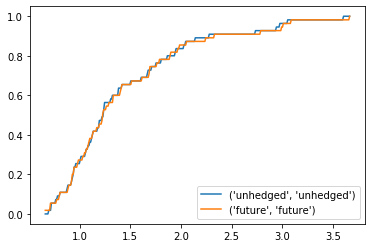

In [150]:
r1 = results[CR_pairs[0]]
r2 = results[CR_pairs[1]]
ecdf1 = ECDF(r1)
ecdf2 = ECDF(r2)

_min = np.min([np.min(r1), np.min(r2)]) # find a common support for two incomes
_max = np.max([np.max(r1), np.max(r2)])
x = np.linspace(_min, _max, n_grids) # grids
print(_min, _max)
plt.plot(x, ecdf1(x), label=CR_pairs[0])
plt.plot(x, ecdf2(x), label=CR_pairs[1])
plt.legend()

In [151]:
pair1 = "(Frank, Variance)"

C1 = pair1[1:pair1.find(', ')]
R1 = pair1[pair1.find(', ')+2:-1]
pair1 = (C1, R1)

r1 = np.array(results[pair1])
r2 = np.ones(len(r1))
run(r1, r2, j=2)

P-value = 0.608
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.698
Cannot reject Null; r2 is domaining r1 OR r2==r1


(0, 0)

In [152]:
Ha_arr = []
Hb_arr = []

for i, pair1 in enumerate(CR_pairs):
    r1 = np.array(results[pair1])
    r2 = np.ones(len(r1))
    Ha, Hb = (run(r1, r2, j=2))
    Ha_arr.append(Ha)
    Hb_arr.append(Hb)
    print(pair1, Ha, Hb)

P-value = 0.584
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.772
Cannot reject Null; r2 is domaining r1 OR r2==r1
('unhedged', 'unhedged') 0 0
P-value = 0.598
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.78
Cannot reject Null; r2 is domaining r1 OR r2==r1
('future', 'future') 0 0
P-value = 0.63
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.736
Cannot reject Null; r2 is domaining r1 OR r2==r1
('Gaussian', 'Variance') 0 0
P-value = 0.7
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.688
Cannot reject Null; r2 is domaining r1 OR r2==r1
('Gaussian', 'VaR 99%') 0 0
P-value = 0.628
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.708
Cannot reject Null; r2 is domaining r1 OR r2==r1
('Gaussian', 'VaR 95%') 0 0
P-value = 0.694
Cannot reject Null; r2 is domaining r1 OR r2==r1
P-value = 0.698
Cannot reject Null; r2 is domaining r1 OR r2==r1
('Gaussian', 'ES 99%') 0 0
P-value = 0.66
Cannot reject Null; r2 is domaining r1 OR r

In [153]:
SOSD.loc['target', :] = Hb_arr + [1001]

ValueError: could not broadcast input array from shape (51,) into shape (50,)

In [ ]:
SOSD.loc[:, 'target'] = Ha_arr + [1001]

In [ ]:
SOSD

In [ ]:
with open(save_file, 'wb') as handle:
    pickle.dump(SOSD, handle)

In [ ]:
[(Ha_arr[i], Hb_arr[i]) for i in range(len(Ha_arr))]